In [1]:
"""Import modules required to run the Jupyter notebook."""

import logging
import warnings

import matplotlib as mpl
import numpy as np
from huggingface_hub import notebook_login

from tiatoolbox.models.architecture.vanilla import TimmBackbone
from tiatoolbox.models.engine.semantic_segmentor import (
    DeepFeatureExtractor,
    IOSegmentorConfig,
)
import cv2
from tiatoolbox.wsicore.wsireader import WSIReader
from tiatoolbox.tools import stainnorm
from matplotlib import pyplot as plt


if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

mpl.rcParams["figure.dpi"] = 300  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode
device = "cuda"

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import os


|2025-07-11|13:55:52.808| [WARNING] c:\Users\m139105\Documents\phd\uni\.venv\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()



In [ ]:
notebook_login()

Vahadane stain extraction/normalization algorithms are unstable after the update to `dictionary learning` algorithm in scikit-learn > v0.23.0 (see issue #382). Please be advised and consider using other stain extraction (normalization) algorithms.


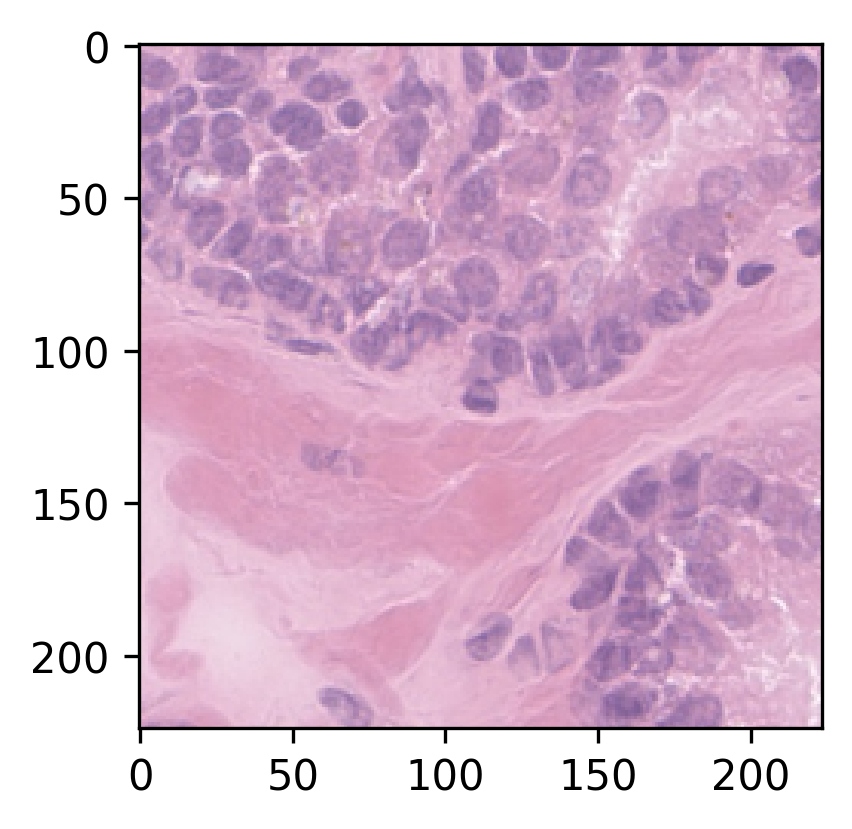

In [ ]:

tile_size = 224
stride = 224

wsi = WSIReader.open(input_img="input/s_17_HE.svs")
wsi_width, wsi_height = wsi.slide_dimensions(resolution=0.5, units="mpp")
location = (23591, 59857)
size = (224, 224)
target_img = wsi.read_rect(
    location,
    (tile_size, tile_size),
    resolution=0.5,
    units="mpp",
)

normalizer = stainnorm.VahadaneNormalizer()
normalizer.fit(target_img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(target_img)
plt.show()

In [4]:
from tiatoolbox.tools.patchextraction import SlidingWindowPatchExtractor
from tqdm import tqdm

wsi = WSIReader.open(input_img="input/s_17_HE.svs")
wsi_width, wsi_height = wsi.slide_dimensions(resolution=0.5, units="mpp")
location = (23591, 59857)
size = (224, 224)
target_img = wsi.read_rect(
    location,
    (tile_size, tile_size),
    resolution=0.5,
    units="mpp",
)

normalizer = stainnorm.VahadaneNormalizer()
normalizer.fit(target_img)

slides_dir = "input/"
all_slides = [os.path.join(slides_dir, f) for f in os.listdir(slides_dir) if f.endswith('.svs')]

for eachslide in tqdm(all_slides, desc="Processing Slides"):

    slidename = eachslide.split("_")[0] + "_" + eachslide.split("_")[1] + "_" + eachslide.split("_")[2]
    slidename = slidename.replace("input/","")
    

    wsi = WSIReader.open(input_img=eachslide)

    print(f"Processing slide extractor: {slidename}")

    extractor = SlidingWindowPatchExtractor(
        input_img=wsi,
        patch_size=(224, 224),
        stride=(224, 224),
        resolution=0.5,
        units="mpp"
    )

    normalized_patches = []
    for patch in tqdm(extractor, total=len(extractor), desc="Extracting + Normalizing Patches"):
        img = patch

        if img.ndim != 3 or img.shape[2] != 3:
            continue

        # Skip blank patches
        white_ratio = (img > 220).mean()
        if white_ratio > 0.8:
            continue

        norm_img = normalizer.transform(img)
        normalized_patches.append(norm_img)


    print(f"Extracted and normalized {len(normalized_patches)} patches.")

    import torch

    print("Working on Prov-Gigapath model")

    model = TimmBackbone(backbone="prov-gigapath", pretrained=True)
    model = model.to(device)
    model.eval()

    features = []
    batch_size = 32
    for i in range(0, len(normalized_patches), batch_size):
        batch = normalized_patches[i:i+batch_size]
        batch_tensor = torch.from_numpy(np.stack(batch)).permute(0, 3, 1, 2).float().to(device)
        with torch.no_grad():
            feat = model(batch_tensor)
        features.append(feat.cpu().numpy())

    features = np.concatenate(features, axis=0)
    np.save("wsi_features/prov/" + slidename + "_features.npy", features)

    print("Working on Optimus model")

    model = TimmBackbone(backbone="H-optimus-0", pretrained=True)
    model = model.to(device)
    model.eval()

    features = []
    batch_size = 32
    for i in range(0, len(normalized_patches), batch_size):
        batch = normalized_patches[i:i+batch_size]
        batch_tensor = torch.from_numpy(np.stack(batch)).permute(0, 3, 1, 2).float().to(device)
        with torch.no_grad():
            feat = model(batch_tensor)
        features.append(feat.cpu().numpy())

    features = np.concatenate(features, axis=0)
    np.save("wsi_features/optimus/" + slidename + "_features.npy", features)


Vahadane stain extraction/normalization algorithms are unstable after the update to `dictionary learning` algorithm in scikit-learn > v0.23.0 (see issue #382). Please be advised and consider using other stain extraction (normalization) algorithms.
Processing Slides:   0%|          | 0/150 [00:00<?, ?it/s]

Processing slide extractor: s_10_1


Extracting + Normalizing Patches: 100%|██████████| 23652/23652 [08:48<00:00, 44.72it/s] 


Extracted and normalized 8414 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   1%|          | 1/150 [20:00<49:41:36, 1200.65s/it]

Processing slide extractor: s_10_2


Extracting + Normalizing Patches: 100%|██████████| 23989/23989 [08:45<00:00, 45.61it/s] 


Extracted and normalized 8391 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   1%|▏         | 2/150 [40:10<49:34:54, 1206.05s/it]

Processing slide extractor: s_10_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 24420/24420 [08:48<00:00, 46.17it/s]


Extracted and normalized 8447 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   2%|▏         | 3/150 [1:00:14<49:12:10, 1204.97s/it]

Processing slide extractor: s_11_1


Extracting + Normalizing Patches: 100%|██████████| 31152/31152 [13:29<00:00, 38.48it/s] 


Extracted and normalized 14342 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   3%|▎         | 4/150 [1:32:11<60:16:08, 1486.08s/it]

Processing slide extractor: s_11_2


Extracting + Normalizing Patches: 100%|██████████| 33807/33807 [13:40<00:00, 41.18it/s] 


Extracted and normalized 14186 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   3%|▎         | 5/150 [2:04:05<66:04:40, 1640.56s/it]

Processing slide extractor: s_11_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 32399/32399 [14:08<00:00, 38.20it/s] 


Extracted and normalized 15291 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   4%|▍         | 6/150 [2:37:54<70:54:20, 1772.64s/it]

Processing slide extractor: s_12_1


Extracting + Normalizing Patches: 100%|██████████| 46295/46295 [16:11<00:00, 47.66it/s] 


Extracted and normalized 14981 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   5%|▍         | 7/150 [3:13:26<75:04:56, 1890.19s/it]

Processing slide extractor: s_12_2


Extracting + Normalizing Patches: 100%|██████████| 46413/46413 [16:03<00:00, 48.19it/s] 


Extracted and normalized 14793 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   5%|▌         | 8/150 [3:48:34<77:17:10, 1959.37s/it]

Processing slide extractor: s_12_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 44885/44885 [12:28<00:00, 59.94it/s] 


Extracted and normalized 9289 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   6%|▌         | 9/150 [4:13:14<70:52:04, 1809.39s/it]

Processing slide extractor: s_13_1


Extracting + Normalizing Patches: 100%|██████████| 10912/10912 [03:25<00:00, 53.13it/s] 


Extracted and normalized 2918 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   7%|▋         | 10/150 [4:21:02<54:16:00, 1395.43s/it]

Processing slide extractor: s_13_2


Extracting + Normalizing Patches: 100%|██████████| 10947/10947 [03:33<00:00, 51.20it/s] 


Extracted and normalized 3062 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   7%|▋         | 11/150 [4:29:07<43:06:55, 1116.66s/it]

Processing slide extractor: s_13_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 11266/11266 [03:41<00:00, 50.96it/s] 


Extracted and normalized 3213 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   8%|▊         | 12/150 [4:37:29<35:38:34, 929.81s/it] 

Processing slide extractor: s_15_1


Extracting + Normalizing Patches: 100%|██████████| 18070/18070 [06:52<00:00, 43.82it/s] 


Extracted and normalized 6691 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   9%|▊         | 13/150 [4:53:27<35:42:29, 938.32s/it]

Processing slide extractor: s_15_2


Extracting + Normalizing Patches: 100%|██████████| 18348/18348 [06:50<00:00, 44.73it/s] 


Extracted and normalized 6533 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:   9%|▉         | 14/150 [5:09:09<35:29:13, 939.37s/it]

Processing slide extractor: s_15_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 18348/18348 [07:06<00:00, 43.01it/s] 


Extracted and normalized 7120 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  10%|█         | 15/150 [5:25:44<35:51:25, 956.19s/it]

Processing slide extractor: s_16_1


Extracting + Normalizing Patches: 100%|██████████| 24786/24786 [10:02<00:00, 41.16it/s] 


Extracted and normalized 10250 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  11%|█         | 16/150 [5:49:35<40:54:25, 1098.99s/it]

Processing slide extractor: s_16_2


Extracting + Normalizing Patches: 100%|██████████| 24160/24160 [09:39<00:00, 41.68it/s] 


Extracted and normalized 9723 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  11%|█▏        | 17/150 [6:12:21<43:34:35, 1179.51s/it]

Processing slide extractor: s_16_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 23989/23989 [09:37<00:00, 41.55it/s] 


Extracted and normalized 9784 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  12%|█▏        | 18/150 [6:35:13<45:21:56, 1237.25s/it]

Processing slide extractor: s_17_1


Extracting + Normalizing Patches: 100%|██████████| 21746/21746 [08:22<00:00, 43.30it/s] 


Extracted and normalized 8161 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  13%|█▎        | 19/150 [6:54:46<44:19:16, 1217.99s/it]

Processing slide extractor: s_17_2


Extracting + Normalizing Patches: 100%|██████████| 22794/22794 [07:50<00:00, 48.50it/s] 


Extracted and normalized 7139 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  13%|█▎        | 20/150 [7:12:29<42:18:20, 1171.54s/it]

Processing slide extractor: s_17_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 25344/25344 [09:23<00:00, 44.95it/s]


Extracted and normalized 8993 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  14%|█▍        | 21/150 [7:34:07<43:20:14, 1209.42s/it]

Processing slide extractor: s_18_1


Extracting + Normalizing Patches: 100%|██████████| 36864/36864 [13:59<00:00, 43.89it/s]


Extracted and normalized 13510 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  15%|█▍        | 22/150 [8:05:28<50:10:13, 1411.05s/it]

Processing slide extractor: s_18_2


Extracting + Normalizing Patches: 100%|██████████| 38793/38793 [13:40<00:00, 47.27it/s]


Extracted and normalized 12559 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  15%|█▌        | 23/150 [8:35:53<54:09:33, 1535.22s/it]

Processing slide extractor: s_18_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 36672/36672 [12:56<00:00, 47.22it/s] 


Extracted and normalized 12186 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  16%|█▌        | 24/150 [9:05:05<56:00:28, 1600.22s/it]

Processing slide extractor: s_1_1


Extracting + Normalizing Patches: 100%|██████████| 31284/31284 [13:03<00:00, 39.95it/s]


Extracted and normalized 13659 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  17%|█▋        | 25/150 [9:36:16<58:23:00, 1681.45s/it]

Processing slide extractor: s_1_2


Extracting + Normalizing Patches: 100%|██████████| 32864/32864 [13:37<00:00, 40.20it/s]


Extracted and normalized 14239 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  17%|█▋        | 26/150 [10:08:44<60:40:33, 1761.56s/it]

Processing slide extractor: s_1_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 32864/32864 [13:22<00:00, 40.97it/s] 


Extracted and normalized 14096 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  18%|█▊        | 27/150 [10:40:48<61:50:56, 1810.22s/it]

Processing slide extractor: s_21_1


Extracting + Normalizing Patches: 100%|██████████| 33631/33631 [13:29<00:00, 41.57it/s] 


Extracted and normalized 13594 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  19%|█▊        | 28/150 [11:12:20<62:10:46, 1834.81s/it]

Processing slide extractor: s_21_2


Extracting + Normalizing Patches: 100%|██████████| 34125/34125 [12:37<00:00, 45.05it/s] 


Extracted and normalized 12267 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  19%|█▉        | 29/150 [11:41:19<60:42:13, 1806.06s/it]

Processing slide extractor: s_21_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 34884/34884 [13:10<00:00, 44.12it/s]


Extracted and normalized 13205 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  20%|██        | 30/150 [12:12:03<60:34:59, 1817.49s/it]

Processing slide extractor: s_22_1


Extracting + Normalizing Patches: 100%|██████████| 19880/19880 [07:21<00:00, 45.03it/s] 


Extracted and normalized 7222 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  21%|██        | 31/150 [12:29:21<52:20:39, 1583.53s/it]

Processing slide extractor: s_22_2


Extracting + Normalizing Patches: 100%|██████████| 21736/21736 [07:55<00:00, 45.74it/s] 


Extracted and normalized 7787 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  21%|██▏       | 32/150 [12:47:34<47:04:36, 1436.24s/it]

Processing slide extractor: s_22_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 22320/22320 [08:44<00:00, 42.53it/s] 


Extracted and normalized 8973 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  22%|██▏       | 33/150 [13:07:59<44:37:05, 1372.87s/it]

Processing slide extractor: s_23_1


Extracting + Normalizing Patches: 100%|██████████| 21900/21900 [06:58<00:00, 52.28it/s] 


Extracted and normalized 6069 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  23%|██▎       | 34/150 [13:23:03<39:42:11, 1232.17s/it]

Processing slide extractor: s_23_2


Extracting + Normalizing Patches: 100%|██████████| 19964/19964 [06:44<00:00, 49.38it/s] 


Extracted and normalized 6295 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  23%|██▎       | 35/150 [13:38:11<36:15:25, 1135.01s/it]

Processing slide extractor: s_23_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 21888/21888 [06:54<00:00, 52.85it/s] 


Extracted and normalized 6030 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  24%|██▍       | 36/150 [13:53:09<33:41:24, 1063.90s/it]

Processing slide extractor: s_24_1


Extracting + Normalizing Patches: 100%|██████████| 25479/25479 [08:12<00:00, 51.72it/s] 


Extracted and normalized 7030 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  25%|██▍       | 37/150 [14:10:40<33:16:23, 1060.03s/it]

Processing slide extractor: s_24_2


Extracting + Normalizing Patches: 100%|██████████| 19712/19712 [07:04<00:00, 46.44it/s] 


Extracted and normalized 6694 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  25%|██▌       | 38/150 [14:26:41<32:03:19, 1030.35s/it]

Processing slide extractor: s_24_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 20502/20502 [07:10<00:00, 47.61it/s] 


Extracted and normalized 6766 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  26%|██▌       | 39/150 [14:42:50<31:11:54, 1011.84s/it]

Processing slide extractor: s_26_1


Extracting + Normalizing Patches: 100%|██████████| 22294/22294 [07:48<00:00, 47.60it/s] 


Extracted and normalized 7226 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  27%|██▋       | 40/150 [15:00:11<31:11:03, 1020.58s/it]

Processing slide extractor: s_26_2


Extracting + Normalizing Patches: 100%|██████████| 23232/23232 [07:52<00:00, 49.17it/s] 


Extracted and normalized 7300 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  27%|██▋       | 41/150 [15:17:40<31:09:39, 1029.17s/it]

Processing slide extractor: s_26_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 22270/22270 [07:51<00:00, 47.25it/s] 


Extracted and normalized 7471 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  28%|██▊       | 42/150 [15:35:22<31:10:09, 1038.97s/it]

Processing slide extractor: s_27_1


Extracting + Normalizing Patches: 100%|██████████| 14732/14732 [05:13<00:00, 47.03it/s]


Extracted and normalized 5030 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  29%|██▊       | 43/150 [15:47:26<28:04:42, 944.70s/it] 

Processing slide extractor: s_27_2


Extracting + Normalizing Patches: 100%|██████████| 15795/15795 [05:39<00:00, 46.48it/s] 


Extracted and normalized 5467 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  29%|██▉       | 44/150 [16:00:31<26:24:01, 896.62s/it]

Processing slide extractor: s_27_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 16472/16472 [05:45<00:00, 47.65it/s] 


Extracted and normalized 5529 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  30%|███       | 45/150 [16:13:45<25:15:04, 865.76s/it]

Processing slide extractor: s_28_1


Extracting + Normalizing Patches: 100%|██████████| 24282/24282 [09:52<00:00, 40.98it/s] 


Extracted and normalized 10147 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  31%|███       | 46/150 [16:36:44<29:27:35, 1019.77s/it]

Processing slide extractor: s_28_2


Extracting + Normalizing Patches: 100%|██████████| 25092/25092 [10:28<00:00, 39.94it/s] 


Extracted and normalized 10688 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  31%|███▏      | 47/150 [17:00:56<32:53:15, 1149.47s/it]

Processing slide extractor: s_28_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 26180/26180 [10:10<00:00, 42.90it/s] 


Extracted and normalized 10375 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  32%|███▏      | 48/150 [17:24:32<34:50:00, 1229.41s/it]

Processing slide extractor: s_2_1


Extracting + Normalizing Patches: 100%|██████████| 37611/37611 [14:30<00:00, 43.22it/s] 


Extracted and normalized 14596 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  33%|███▎      | 49/150 [17:57:34<40:49:38, 1455.24s/it]

Processing slide extractor: s_2_2


Extracting + Normalizing Patches: 100%|██████████| 37800/37800 [13:58<00:00, 45.10it/s] 


Extracted and normalized 13898 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  33%|███▎      | 50/150 [18:29:13<44:07:21, 1588.41s/it]

Processing slide extractor: s_2_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 38367/38367 [13:05<00:00, 48.83it/s] 


Extracted and normalized 12783 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  34%|███▍      | 51/150 [18:58:37<45:07:49, 1641.11s/it]

Processing slide extractor: s_30_1


Extracting + Normalizing Patches: 100%|██████████| 25654/25654 [09:24<00:00, 45.47it/s] 


Extracted and normalized 9124 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  35%|███▍      | 52/150 [19:19:55<41:42:20, 1532.04s/it]

Processing slide extractor: s_30_2


Extracting + Normalizing Patches: 100%|██████████| 26780/26780 [09:42<00:00, 45.94it/s] 


Extracted and normalized 9429 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  35%|███▌      | 53/150 [19:41:51<39:32:07, 1467.29s/it]

Processing slide extractor: s_30_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 26624/26624 [10:03<00:00, 44.11it/s] 


Extracted and normalized 10123 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  36%|███▌      | 54/150 [20:04:59<38:29:52, 1443.67s/it]

Processing slide extractor: s_31_1


Extracting + Normalizing Patches: 100%|██████████| 22680/22680 [08:21<00:00, 45.18it/s] 


Extracted and normalized 8315 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  37%|███▋      | 55/150 [20:24:16<35:49:13, 1357.41s/it]

Processing slide extractor: s_31_2


Extracting + Normalizing Patches: 100%|██████████| 22388/22388 [08:36<00:00, 43.35it/s] 


Extracted and normalized 8781 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  37%|███▋      | 56/150 [20:44:16<34:12:53, 1310.36s/it]

Processing slide extractor: s_31_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 26130/26130 [09:44<00:00, 44.71it/s] 


Extracted and normalized 9677 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  38%|███▊      | 57/150 [21:06:32<34:02:50, 1317.96s/it]

Processing slide extractor: s_32_1


Extracting + Normalizing Patches: 100%|██████████| 28496/28496 [11:47<00:00, 40.30it/s] 


Extracted and normalized 12435 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  39%|███▊      | 58/150 [21:34:12<36:18:29, 1420.76s/it]

Processing slide extractor: s_32_2


Extracting + Normalizing Patches: 100%|██████████| 27872/27872 [11:18<00:00, 41.09it/s] 


Extracted and normalized 12018 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  39%|███▉      | 59/150 [22:00:53<37:16:41, 1474.74s/it]

Processing slide extractor: s_32_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 28496/28496 [11:54<00:00, 39.87it/s] 


Extracted and normalized 13086 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  40%|████      | 60/150 [22:29:30<38:40:56, 1547.30s/it]

Processing slide extractor: s_34_1


Extracting + Normalizing Patches: 100%|██████████| 29412/29412 [10:22<00:00, 47.25it/s] 


Extracted and normalized 9809 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  41%|████      | 61/150 [22:52:32<37:01:36, 1497.71s/it]

Processing slide extractor: s_34_2


Extracting + Normalizing Patches: 100%|██████████| 30260/30260 [10:33<00:00, 47.74it/s] 


Extracted and normalized 10085 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  41%|████▏     | 62/150 [23:16:07<36:00:30, 1473.08s/it]

Processing slide extractor: s_34_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 34209/34209 [11:01<00:00, 51.72it/s] 


Extracted and normalized 9892 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  42%|████▏     | 63/150 [23:39:54<35:15:35, 1459.03s/it]

Processing slide extractor: s_35_1


Extracting + Normalizing Patches: 100%|██████████| 21736/21736 [06:46<00:00, 53.44it/s] 


Extracted and normalized 5810 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  43%|████▎     | 64/150 [23:54:33<30:42:06, 1285.19s/it]

Processing slide extractor: s_35_2


Extracting + Normalizing Patches: 100%|██████████| 23908/23908 [07:25<00:00, 53.66it/s] 


Extracted and normalized 6271 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  43%|████▎     | 65/150 [24:10:28<28:00:25, 1186.18s/it]

Processing slide extractor: s_35_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 21605/21605 [07:19<00:00, 49.13it/s] 


Extracted and normalized 6649 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  44%|████▍     | 66/150 [24:26:49<26:14:20, 1124.53s/it]

Processing slide extractor: s_36_1


Extracting + Normalizing Patches: 100%|██████████| 13664/13664 [04:58<00:00, 45.75it/s] 


Extracted and normalized 4685 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  45%|████▍     | 67/150 [24:38:20<22:55:37, 994.43s/it] 

Processing slide extractor: s_36_2


Extracting + Normalizing Patches: 100%|██████████| 16459/16459 [05:43<00:00, 47.89it/s] 


Extracted and normalized 5381 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  45%|████▌     | 68/150 [24:51:30<21:15:17, 933.14s/it]

Processing slide extractor: s_36_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 14560/14560 [05:20<00:00, 45.38it/s] 


Extracted and normalized 5391 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  46%|████▌     | 69/150 [25:04:17<19:52:23, 883.25s/it]

Processing slide extractor: s_38_1


Extracting + Normalizing Patches: 100%|██████████| 23944/23944 [09:38<00:00, 41.42it/s] 


Extracted and normalized 9610 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  47%|████▋     | 70/150 [25:26:36<22:40:06, 1020.08s/it]

Processing slide extractor: s_38_2


Extracting + Normalizing Patches: 100%|██████████| 25434/25434 [10:26<00:00, 40.60it/s] 


Extracted and normalized 10655 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  47%|████▋     | 71/150 [25:50:57<25:17:17, 1152.37s/it]

Processing slide extractor: s_38_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 24960/24960 [10:04<00:00, 41.27it/s] 


Extracted and normalized 10494 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  48%|████▊     | 72/150 [26:14:45<26:45:40, 1235.14s/it]

Processing slide extractor: s_39_1


Extracting + Normalizing Patches: 100%|██████████| 14616/14616 [05:41<00:00, 42.86it/s] 


Extracted and normalized 5589 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  49%|████▊     | 73/150 [26:28:06<23:37:38, 1104.65s/it]

Processing slide extractor: s_39_2


Extracting + Normalizing Patches: 100%|██████████| 14868/14868 [05:40<00:00, 43.67it/s] 


Extracted and normalized 5671 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  49%|████▉     | 74/150 [26:41:31<21:25:27, 1014.83s/it]

Processing slide extractor: s_39_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 15589/15589 [06:00<00:00, 43.25it/s] 


Extracted and normalized 6071 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  50%|█████     | 75/150 [26:55:49<20:09:46, 967.82s/it] 

Processing slide extractor: s_3_1


Extracting + Normalizing Patches: 100%|██████████| 11880/11880 [04:09<00:00, 47.62it/s] 


Extracted and normalized 3765 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  51%|█████     | 76/150 [27:05:19<17:26:21, 848.40s/it]

Processing slide extractor: s_3_2


Extracting + Normalizing Patches: 100%|██████████| 12432/12432 [04:17<00:00, 48.32it/s] 


Extracted and normalized 3923 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  51%|█████▏    | 77/150 [27:15:13<15:39:22, 772.09s/it]

Processing slide extractor: s_3_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 12317/12317 [04:05<00:00, 50.26it/s] 


Extracted and normalized 3623 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  52%|█████▏    | 78/150 [27:24:33<14:10:10, 708.49s/it]

Processing slide extractor: s_40_1


Extracting + Normalizing Patches: 100%|██████████| 14850/14850 [05:48<00:00, 42.65it/s] 


Extracted and normalized 5668 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  53%|█████▎    | 79/150 [27:38:09<14:36:41, 740.87s/it]

Processing slide extractor: s_40_2


Extracting + Normalizing Patches: 100%|██████████| 15048/15048 [05:32<00:00, 45.20it/s] 


Extracted and normalized 5215 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  53%|█████▎    | 80/150 [27:50:57<14:33:45, 748.93s/it]

Processing slide extractor: s_40_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 14985/14985 [06:07<00:00, 40.73it/s] 


Extracted and normalized 6301 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  54%|█████▍    | 81/150 [28:05:35<15:05:50, 787.69s/it]

Processing slide extractor: s_41_1


Extracting + Normalizing Patches: 100%|██████████| 25718/25718 [09:25<00:00, 45.49it/s] 


Extracted and normalized 8908 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  55%|█████▍    | 82/150 [28:26:42<17:35:27, 931.28s/it]

Processing slide extractor: s_41_2


Extracting + Normalizing Patches: 100%|██████████| 26062/26062 [09:36<00:00, 45.21it/s] 


Extracted and normalized 9162 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  55%|█████▌    | 83/150 [28:48:23<19:24:02, 1042.42s/it]

Processing slide extractor: s_41_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 28124/28124 [09:46<00:00, 47.96it/s] 


Extracted and normalized 9074 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  56%|█████▌    | 84/150 [29:10:09<20:33:41, 1121.54s/it]

Processing slide extractor: s_43_1


Extracting + Normalizing Patches: 100%|██████████| 22000/22000 [08:35<00:00, 42.69it/s] 


Extracted and normalized 8404 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  57%|█████▋    | 85/150 [29:29:55<20:35:43, 1140.67s/it]

Processing slide extractor: s_43_2


Extracting + Normalizing Patches: 100%|██████████| 23478/23478 [08:41<00:00, 45.06it/s] 


Extracted and normalized 8387 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  57%|█████▋    | 86/150 [29:49:48<20:33:34, 1156.48s/it]

Processing slide extractor: s_43_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 21576/21576 [07:20<00:00, 48.93it/s] 


Extracted and normalized 7101 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  58%|█████▊    | 87/150 [30:06:40<19:28:43, 1113.08s/it]

Processing slide extractor: s_44_1


Extracting + Normalizing Patches: 100%|██████████| 32319/32319 [11:58<00:00, 44.95it/s] 


Extracted and normalized 11954 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  59%|█████▊    | 88/150 [30:34:02<21:54:11, 1271.80s/it]

Processing slide extractor: s_44_2


Extracting + Normalizing Patches: 100%|██████████| 32130/32130 [11:44<00:00, 45.58it/s] 


Extracted and normalized 11632 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  59%|█████▉    | 89/150 [31:00:55<23:16:56, 1374.04s/it]

Processing slide extractor: s_44_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 33250/33250 [12:24<00:00, 44.67it/s]


Extracted and normalized 12554 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  60%|██████    | 90/150 [31:29:37<24:38:39, 1478.65s/it]

Processing slide extractor: s_45_1


Extracting + Normalizing Patches: 100%|██████████| 22500/22500 [07:53<00:00, 47.50it/s] 


Extracted and normalized 7238 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  61%|██████    | 91/150 [31:47:15<22:09:45, 1352.30s/it]

Processing slide extractor: s_45_2


Extracting + Normalizing Patches: 100%|██████████| 19872/19872 [07:10<00:00, 46.20it/s] 


Extracted and normalized 6766 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  61%|██████▏   | 92/150 [32:03:40<20:00:46, 1242.19s/it]

Processing slide extractor: s_45_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 19881/19881 [05:59<00:00, 55.27it/s] 


Extracted and normalized 4823 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  62%|██████▏   | 93/150 [32:16:26<17:24:23, 1099.35s/it]

Processing slide extractor: s_46_1


Extracting + Normalizing Patches: 100%|██████████| 18125/18125 [06:38<00:00, 45.46it/s] 


Extracted and normalized 6223 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  63%|██████▎   | 94/150 [32:31:32<16:11:43, 1041.14s/it]

Processing slide extractor: s_46_2


Extracting + Normalizing Patches: 100%|██████████| 18900/18900 [06:58<00:00, 45.12it/s] 


Extracted and normalized 6663 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  63%|██████▎   | 95/150 [32:47:25<15:30:14, 1014.81s/it]

Processing slide extractor: s_46_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 18942/18942 [05:46<00:00, 54.66it/s]


Extracted and normalized 4816 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  64%|██████▍   | 96/150 [33:00:02<14:03:38, 937.38s/it] 

Processing slide extractor: s_47_1


Extracting + Normalizing Patches: 100%|██████████| 26624/26624 [08:54<00:00, 49.79it/s] 


Extracted and normalized 7894 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  65%|██████▍   | 97/150 [33:19:46<14:53:22, 1011.37s/it]

Processing slide extractor: s_47_2


Extracting + Normalizing Patches: 100%|██████████| 27248/27248 [08:53<00:00, 51.04it/s] 


Extracted and normalized 7668 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  65%|██████▌   | 98/150 [33:39:12<15:16:49, 1057.88s/it]

Processing slide extractor: s_47_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 28496/28496 [09:46<00:00, 48.59it/s] 


Extracted and normalized 8795 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  66%|██████▌   | 99/150 [34:00:56<16:02:02, 1131.81s/it]

Processing slide extractor: s_49_1


Extracting + Normalizing Patches: 100%|██████████| 24492/24492 [07:34<00:00, 53.83it/s] 


Extracted and normalized 6246 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  67%|██████▋   | 100/150 [34:17:17<15:05:16, 1086.34s/it]

Processing slide extractor: s_49_2


Extracting + Normalizing Patches: 100%|██████████| 25872/25872 [08:02<00:00, 53.61it/s] 


Extracted and normalized 6660 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  67%|██████▋   | 101/150 [34:34:35<14:35:33, 1072.11s/it]

Processing slide extractor: s_49_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 31164/31164 [09:01<00:00, 57.54it/s] 


Extracted and normalized 7047 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  68%|██████▊   | 102/150 [34:53:06<14:26:55, 1083.66s/it]

Processing slide extractor: s_4_1


Extracting + Normalizing Patches: 100%|██████████| 23667/23667 [08:45<00:00, 45.05it/s] 


Extracted and normalized 8327 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  69%|██████▊   | 103/150 [35:12:55<14:33:31, 1115.14s/it]

Processing slide extractor: s_4_2


Extracting + Normalizing Patches: 100%|██████████| 25080/25080 [09:23<00:00, 44.51it/s] 


Extracted and normalized 8904 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  69%|██████▉   | 104/150 [35:34:05<14:50:40, 1161.74s/it]

Processing slide extractor: s_4_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 23373/23373 [08:33<00:00, 45.54it/s] 


Extracted and normalized 8327 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  70%|███████   | 105/150 [35:53:42<14:34:48, 1166.42s/it]

Processing slide extractor: s_50_1


Extracting + Normalizing Patches: 100%|██████████| 32832/32832 [11:44<00:00, 46.60it/s]


Extracted and normalized 11279 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  71%|███████   | 106/150 [36:20:08<15:47:31, 1292.07s/it]

Processing slide extractor: s_50_2


Extracting + Normalizing Patches: 100%|██████████| 30276/30276 [11:23<00:00, 44.28it/s] 


Extracted and normalized 11348 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  71%|███████▏  | 107/150 [36:46:45<16:31:34, 1383.60s/it]

Processing slide extractor: s_50_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 28557/28557 [10:50<00:00, 43.93it/s] 


Extracted and normalized 11057 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  72%|███████▏  | 108/150 [37:12:25<16:41:26, 1430.63s/it]

Processing slide extractor: s_52_1


Extracting + Normalizing Patches: 100%|██████████| 21672/21672 [08:29<00:00, 42.54it/s] 


Extracted and normalized 8358 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  73%|███████▎  | 109/150 [37:32:20<15:29:11, 1359.80s/it]

Processing slide extractor: s_52_2


Extracting + Normalizing Patches: 100%|██████████| 22078/22078 [08:26<00:00, 43.55it/s] 


Extracted and normalized 8262 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  73%|███████▎  | 110/150 [37:52:06<14:31:46, 1307.66s/it]

Processing slide extractor: s_52_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 21414/21414 [08:01<00:00, 44.48it/s] 


Extracted and normalized 7972 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  74%|███████▍  | 111/150 [38:10:34<13:31:03, 1247.77s/it]

Processing slide extractor: s_53_1


Extracting + Normalizing Patches: 100%|██████████| 27056/27056 [08:36<00:00, 52.37it/s] 


Extracted and normalized 7332 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  75%|███████▍  | 112/150 [38:28:50<12:41:25, 1202.26s/it]

Processing slide extractor: s_53_2


Extracting + Normalizing Patches: 100%|██████████| 22560/22560 [08:09<00:00, 46.10it/s] 


Extracted and normalized 7820 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  75%|███████▌  | 113/150 [38:47:15<12:03:20, 1172.98s/it]

Processing slide extractor: s_53_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 24786/24786 [07:46<00:00, 53.12it/s] 


Extracted and normalized 6613 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  76%|███████▌  | 114/150 [39:03:45<11:10:51, 1118.10s/it]

Processing slide extractor: s_55_1


Extracting + Normalizing Patches: 100%|██████████| 16761/16761 [06:25<00:00, 43.50it/s] 


Extracted and normalized 6439 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  77%|███████▋  | 115/150 [39:18:49<10:14:48, 1053.95s/it]

Processing slide extractor: s_55_2


Extracting + Normalizing Patches: 100%|██████████| 15478/15478 [05:48<00:00, 44.37it/s] 


Extracted and normalized 5819 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  77%|███████▋  | 116/150 [39:32:28<9:17:16, 983.42s/it]  

Processing slide extractor: s_55_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 15180/15180 [05:35<00:00, 45.19it/s] 


Extracted and normalized 5601 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  78%|███████▊  | 117/150 [39:45:37<8:28:46, 925.04s/it]

Processing slide extractor: s_56_1


Extracting + Normalizing Patches: 100%|██████████| 15561/15561 [05:19<00:00, 48.69it/s] 


Extracted and normalized 4858 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  79%|███████▊  | 118/150 [39:57:41<7:41:15, 864.85s/it]

Processing slide extractor: s_56_2


Extracting + Normalizing Patches: 100%|██████████| 18358/18358 [06:04<00:00, 50.34it/s] 


Extracted and normalized 5443 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  79%|███████▉  | 119/150 [40:11:09<7:18:04, 847.88s/it]

Processing slide extractor: s_56_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 16520/16520 [04:51<00:00, 56.63it/s]


Extracted and normalized 4023 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  80%|████████  | 120/150 [40:21:43<6:31:46, 783.55s/it]

Processing slide extractor: s_57_1


Extracting + Normalizing Patches: 100%|██████████| 27872/27872 [09:31<00:00, 48.78it/s] 


Extracted and normalized 8769 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  81%|████████  | 121/150 [40:42:37<7:26:58, 924.78s/it]

Processing slide extractor: s_57_2


Extracting + Normalizing Patches: 100%|██████████| 28085/28085 [07:55<00:00, 59.01it/s] 


Extracted and normalized 6225 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  81%|████████▏ | 122/150 [40:58:51<7:18:23, 939.41s/it]

Processing slide extractor: s_57_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 27265/27265 [07:35<00:00, 59.82it/s]


Extracted and normalized 5806 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  82%|████████▏ | 123/150 [41:14:15<7:00:46, 935.04s/it]

Processing slide extractor: s_58_1


Extracting + Normalizing Patches: 100%|██████████| 30870/30870 [12:02<00:00, 42.70it/s] 


Extracted and normalized 12595 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  83%|████████▎ | 124/150 [41:42:22<8:22:52, 1160.48s/it]

Processing slide extractor: s_58_2


Extracting + Normalizing Patches: 100%|██████████| 43719/43719 [16:15<00:00, 44.82it/s]


Extracted and normalized 15765 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  83%|████████▎ | 125/150 [42:18:30<10:09:25, 1462.62s/it]

Processing slide extractor: s_58_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 34528/34528 [13:54<00:00, 41.37it/s] 


Extracted and normalized 15129 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  84%|████████▍ | 126/150 [42:51:35<10:47:47, 1619.48s/it]

Processing slide extractor: s_59_1


Extracting + Normalizing Patches: 100%|██████████| 26496/26496 [08:50<00:00, 49.96it/s] 


Extracted and normalized 7809 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  85%|████████▍ | 127/150 [43:10:42<9:26:26, 1477.66s/it] 

Processing slide extractor: s_59_2


Extracting + Normalizing Patches: 100%|██████████| 26520/26520 [09:07<00:00, 48.47it/s] 


Extracted and normalized 8353 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  85%|████████▌ | 128/150 [43:30:43<8:31:24, 1394.73s/it]

Processing slide extractor: s_59_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 26520/26520 [09:09<00:00, 48.25it/s] 


Extracted and normalized 8586 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  86%|████████▌ | 129/150 [43:51:02<7:49:41, 1341.98s/it]

Processing slide extractor: s_5_1


Extracting + Normalizing Patches: 100%|██████████| 14873/14873 [04:52<00:00, 50.85it/s] 


Extracted and normalized 4469 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  87%|████████▋ | 130/150 [44:02:06<6:19:32, 1138.61s/it]

Processing slide extractor: s_5_2


Extracting + Normalizing Patches: 100%|██████████| 15792/15792 [05:17<00:00, 49.75it/s]


Extracted and normalized 4935 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  87%|████████▋ | 131/150 [44:14:07<5:20:52, 1013.30s/it]

Processing slide extractor: s_5_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 16215/16215 [05:10<00:00, 52.14it/s] 


Extracted and normalized 4728 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  88%|████████▊ | 132/150 [44:25:46<4:35:40, 918.89s/it] 

Processing slide extractor: s_60_1


Extracting + Normalizing Patches: 100%|██████████| 33768/33768 [13:06<00:00, 42.92it/s] 


Extracted and normalized 13245 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  89%|████████▊ | 133/150 [44:55:48<5:35:29, 1184.10s/it]

Processing slide extractor: s_60_2


Extracting + Normalizing Patches: 100%|██████████| 36579/36579 [13:53<00:00, 43.91it/s] 


Extracted and normalized 13671 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  89%|████████▉ | 134/150 [45:27:07<6:11:17, 1392.34s/it]

Processing slide extractor: s_60_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 35505/35505 [13:36<00:00, 43.49it/s] 


Extracted and normalized 13786 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  90%|█████████ | 135/150 [45:58:13<6:23:38, 1534.58s/it]

Processing slide extractor: s_61_1


Extracting + Normalizing Patches: 100%|██████████| 27792/27792 [08:07<00:00, 56.96it/s] 


Extracted and normalized 6504 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  91%|█████████ | 136/150 [46:15:01<5:21:11, 1376.54s/it]

Processing slide extractor: s_61_2


Extracting + Normalizing Patches: 100%|██████████| 19317/19317 [07:08<00:00, 45.13it/s] 


Extracted and normalized 7239 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  91%|█████████▏| 137/150 [46:31:42<4:33:50, 1263.87s/it]

Processing slide extractor: s_61_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 20196/20196 [07:11<00:00, 46.80it/s]


Extracted and normalized 7164 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  92%|█████████▏| 138/150 [46:48:31<3:57:28, 1187.41s/it]

Processing slide extractor: s_6_1


Extracting + Normalizing Patches: 100%|██████████| 31752/31752 [11:27<00:00, 46.18it/s] 


Extracted and normalized 11686 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  93%|█████████▎| 139/150 [47:15:22<4:00:59, 1314.47s/it]

Processing slide extractor: s_6_2


Extracting + Normalizing Patches: 100%|██████████| 33516/33516 [12:13<00:00, 45.69it/s] 


Extracted and normalized 12798 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  93%|█████████▎| 140/150 [47:44:06<3:59:34, 1437.42s/it]

Processing slide extractor: s_6_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 31752/31752 [11:01<00:00, 47.99it/s] 


Extracted and normalized 11254 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  94%|█████████▍| 141/150 [48:09:49<3:40:20, 1468.95s/it]

Processing slide extractor: s_7_1


Extracting + Normalizing Patches: 100%|██████████| 15996/15996 [05:58<00:00, 44.68it/s] 


Extracted and normalized 5947 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  95%|█████████▍| 142/150 [48:23:54<2:50:54, 1281.76s/it]

Processing slide extractor: s_7_2


Extracting + Normalizing Patches: 100%|██████████| 15544/15544 [05:56<00:00, 43.63it/s] 


Extracted and normalized 6016 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  95%|█████████▌| 143/150 [48:38:03<2:14:24, 1152.09s/it]

Processing slide extractor: s_7_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 16641/16641 [06:15<00:00, 44.30it/s] 


Extracted and normalized 6352 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  96%|█████████▌| 144/150 [48:52:58<1:47:29, 1074.95s/it]

Processing slide extractor: s_8_1


Extracting + Normalizing Patches: 100%|██████████| 10800/10800 [03:39<00:00, 49.28it/s] 


Extracted and normalized 3244 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  97%|█████████▋| 145/150 [49:01:23<1:15:20, 904.07s/it] 

Processing slide extractor: s_8_2


Extracting + Normalizing Patches: 100%|██████████| 10700/10700 [03:39<00:00, 48.72it/s] 


Extracted and normalized 3309 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  97%|█████████▋| 146/150 [49:09:56<52:26, 786.61s/it]  

Processing slide extractor: s_8_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 11110/11110 [03:48<00:00, 48.56it/s] 


Extracted and normalized 3524 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  98%|█████████▊| 147/150 [49:18:49<35:31, 710.59s/it]

Processing slide extractor: s_9_1


Extracting + Normalizing Patches: 100%|██████████| 34496/34496 [13:28<00:00, 42.69it/s] 


Extracted and normalized 13663 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  99%|█████████▊| 148/150 [49:49:52<35:12, 1056.21s/it]

Processing slide extractor: s_9_2


Extracting + Normalizing Patches: 100%|██████████| 33276/33276 [13:23<00:00, 41.41it/s] 


Extracted and normalized 14082 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides:  99%|█████████▉| 149/150 [50:21:20<21:45, 1305.84s/it]

Processing slide extractor: s_9_HE.svs


Extracting + Normalizing Patches: 100%|██████████| 33425/33425 [13:05<00:00, 42.57it/s] 


Extracted and normalized 13872 patches.
Working on Prov-Gigapath model
Working on Optimus model


Processing Slides: 100%|██████████| 150/150 [50:52:13<00:00, 1220.89s/it]
